# Backdoor Unlearning

## Outline

1. Experimental setup (generating configs)
2. Clean model training
3. Poisoned model training
4. First-order unlearning
5. Second-order unlearning
6. Visualizing results


## Experimental Setup

- All configurations to test are defined in the `[train|poison|unlearn].json` files (see below).
- If parameters are passed as list, all their combinations are tested in a grid-search manner.
- Only a single combination is provided for this demo. The original combinations are in `Applications/Poisoning/configs`
- The function generates directories and configuration files for each combination. They are later used by an evaluation script to run the experiment. This allows for parallelization and distributed execution.

In [10]:
import sys
sys.path.append('../')


In [11]:
# only if you are using CUDA devices
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"


In [12]:
from conf import BASE_DIR
from Applications.Poisoning.gen_configs import main as gen_configs

model_folder = BASE_DIR/'models'/'poisoning'
train_conf = BASE_DIR/'Applications'/'Poisoning'/'configs'/'demo'/'train.json'
poison_conf = BASE_DIR/'Applications'/'Poisoning'/'configs'/'demo'/'poison.json'
unlearn_conf = BASE_DIR/'Applications'/'Poisoning'/'configs'/'demo'/'unlearn.json'

gen_configs(model_folder, train_conf, poison_conf, unlearn_conf)

## Clean Model Training

- Train a clean model for reference.

In [13]:
from Applications.Poisoning.train import main as train
from Applications.Poisoning.evaluate import evaluate

# train one clean and one poisoned model
datasets = ['Cifar10', 'Cifar100', 'SVHN', 'FashionMNIST']
modelnames = ['VGG16', 'RESNET50', 'extractfeatures_VGG16', 'extractfeatures_RESNET50', 'classifier_VGG16', 'classifier_RESNET50']


In [14]:
from Applications.Poisoning.poison.poison_models import train_poisoned
from Applications.Poisoning.configs.demo.config import Config

poisoned_folder = model_folder/'budget-10000'/'seed-42'
clean_folder = model_folder/'clean'
first_unlearn_folder = model_folder/'budget-10000'/'seed-42'/'first-order'
second_unlearn_folder = model_folder/'budget-10000'/'seed-42'/'second-order'


poison_kwargs = Config.from_json(poisoned_folder/'poison_config.json')
train_kwargs = Config.from_json(poisoned_folder/'train_config.json')

# train_poisoned(model_folder=poisoned_folder, poison_kwargs=poison_kwargs, train_kwargs=train_kwargs)

# for dataset in datasets:
#     for modelname in modelnames:
#         print('*' * 40)
#         print(f"* Training {modelname} on {dataset} poisoned model *")
#         print('*' * 40)
#         train_poisoned(model_folder=poisoned_folder, dataset=dataset, modelname=modelname)
#         print('*' * 40)
#         print(f"* Evaluating {modelname} on {dataset} poisoned model *")
#         print('*' * 40)
#         evaluate(model_folder=poisoned_folder, dataset=dataset, modelname=modelname)

In [15]:
poisoned_weights = poisoned_folder/'best_model.hdf5'       # model that has been trained on poisoned data
fo_repaired_weights = poisoned_folder/'fo_repaired.hdf5'   # model weights after unlearning (first-order)
so_repaired_weights = poisoned_folder/'so_repaired.hdf5'   # model weights after unlearning (second-order)
injector_path = poisoned_folder/'injector.pkl'             # cached injector for reproducibility
clean_results = model_folder/'clean'/'train_results.json'  # path to reference results on clean dataset


## Unlearning

- Perform the first-order and second-order unlearning. The unlearning is wrapped in a function that
    - loads the clean data, saves the original labels
    - injects the poison (label noise)
    - creates difference set Z using `injector.injected_idx`
    - main unlearning happens in `Applications.Poisoning.unlearn.common.py:unlearn_update` and the thereby called `iter_approx_retraining` method
- The variable naming follows the following ideas:
    - `z_x`, `z_y`: features (x) and labels (y) in set `Z`
    - `z_x_delta`, `z_y_delta`: changed features and labels (`z_x == z_x_delta` here and `z_y_delta` contains the original (fixed) labels)
- A word about why iterative:
    - The approximate retraining is configured to unlearn the desired changes in one step.
    - To avoid putting a lot of redundant erroneous samples in the changing set `Z`, the iterative version
        - takes a sub-sample (`prio_idx`) of `hvp_batch_size` in the delta set `Z`
        - makes one unlearning step
        - recalculates the delta set and focuses only on remaining errors
    - The idea here is that similar to learning, it is better to work iteratively in batches since the approximation quality of the inverse hessian matrix decreases with the number of samples included (and the step size)

In [16]:
from Applications.Poisoning.unlearn.first_order import run_experiment as fo_experiment
from Applications.Poisoning.unlearn.second_order import run_experiment as so_experiment

fo_unlearn_kwargs = Config.from_json(poisoned_folder/'first-order'/'unlearn_config.json')
so_unlearn_kwargs = Config.from_json(poisoned_folder/'second-order'/'unlearn_config.json')


In [ ]:
for dataset in datasets:
    for modelname in modelnames:
        print('*' * 40)
        print(f"* Evaluating {modelname} on {dataset} poisoned model *")
        print('*' * 40)
        evaluate(model_folder=poisoned_folder, dataset=dataset, modelname=modelname, type='poisoned')
        
        print('*' * 40)
        print(f"* First-order unlearning {modelname} on {dataset} poisoned model *")
        print('*' * 40)
        fo_experiment(poisoned_folder, fo_unlearn_kwargs, dataset, modelname, clean_results)
        
        print('*' * 40)
        print(f"* Evaluating {modelname} on {dataset} after first-order unlearning *")
        print('*' * 40)
        evaluate(model_folder=first_unlearn_folder, dataset=dataset, modelname=modelname, type='repaired')

        print('*' * 40)
        print(f"* Second-order unlearning {modelname} on {dataset} poisoned model *")
        print('*' * 40)
        so_experiment(poisoned_folder, so_unlearn_kwargs, dataset, modelname, clean_results)

        print('*' * 40)
        print(f"* Evaluating {modelname} on {dataset} after second-order unlearning *")
        print('*' * 40)
        evaluate(model_folder=second_unlearn_folder, dataset=dataset, modelname=modelname, type='repaired')
        

Model model_weights :None
Loading weights from None
Initial accuracy : 0.8436


2024-07-15 21:40:53.186016: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614400000 exceeds 10% of free system memory.
2024-07-15 21:40:53.463980: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 536870912 exceeds 10% of free system memory.
2024-07-15 21:40:53.526704: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 536870912 exceeds 10% of free system memory.
2024-07-15 21:40:53.595250: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 536870912 exceeds 10% of free system memory.
2024-07-15 21:40:53.664607: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 536870912 exceeds 10% of free system memory.


TypeError: get_inv_hvp_lissa() got an unexpected keyword argument 'tau'

<Figure size 640x480 with 0 Axes>

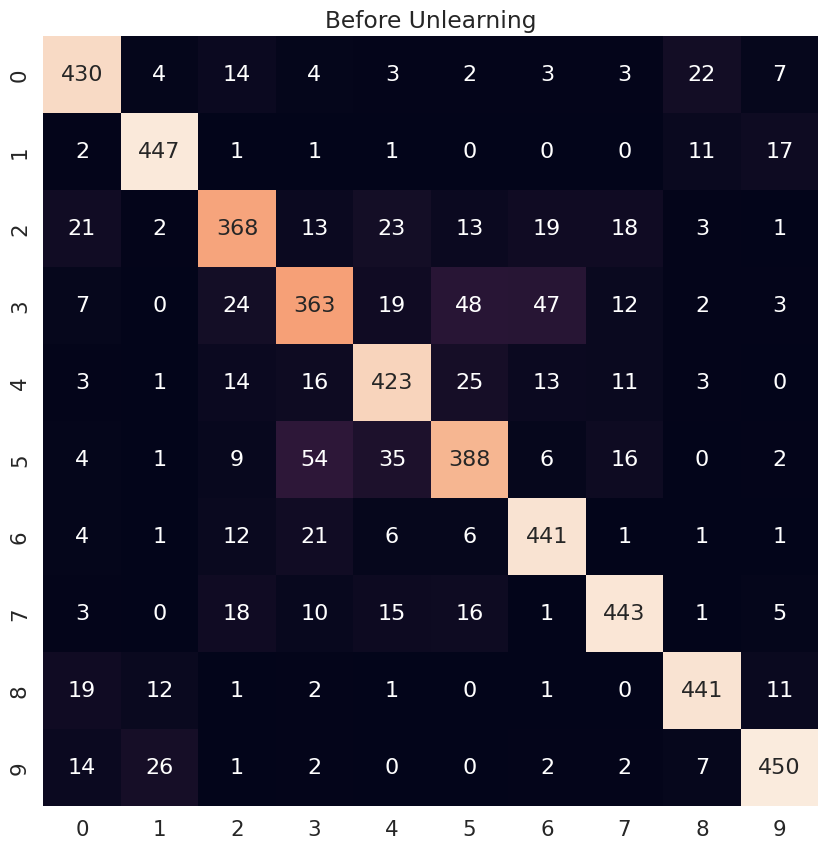

In [18]:
so_experiment(poisoned_folder/'second-order', train_kwargs, poison_kwargs, fo_unlearn_kwargs, dataset='Cifar10', modelname='VGG19', update_target='classifier', prefix='so_clean')